In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import urllib.request
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

import pickle
from sklearn import metrics

import h2o
from h2o.automl import H2OAutoML


#import warnings 
#warnings.filterwarnings("ignore")

In [18]:
# We read the dataframe describing the meaning of the columns
df_info = pd.read_csv("columns_meaning.csv", index_col=0)
df_info

,Description
Column,
0,Case_ID registered in Hospital
1,Unique code for the Hospital
2,Unique code for the type of Hospital
3,City Code of the Hospital
4,Region Code of the Hospital
5,Number of Extra rooms available in the Hospital
6,Department overlooking the case
7,Code for the Ward type
8,Code for the Ward Facility


In [19]:
# We read the hospital data
df_train = pd.read_csv("hospital_train.csv", index_col=0)
df_train

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
0,,,,,,,,,,,,,,,,,
161528,6,a,6,X,2,gynecology,R,F,4.0,45810,2.0,Urgent,Moderate,2,21-30,2817.0,0-10
159472,23,a,6,X,4,gynecology,Q,F,2.0,128565,15.0,Trauma,Moderate,4,51-60,4498.0,21-30
309765,2,c,5,Z,2,anesthesia,S,F,3.0,46565,5.0,Urgent,Moderate,2,71-80,4573.0,11-20
279614,32,f,9,Y,3,gynecology,S,B,4.0,124546,6.0,Emergency,Moderate,4,11-20,7202.0,51-60
147791,14,a,1,X,3,gynecology,S,E,2.0,22729,8.0,Urgent,Moderate,2,51-60,3398.0,51-60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237869,12,a,9,Y,3,gynecology,R,B,3.0,82914,3.0,Emergency,Moderate,6,51-60,3966.0,More than 100 Days
254763,28,b,11,X,2,gynecology,R,F,2.0,40026,5.0,Urgent,Moderate,3,21-30,4005.0,51-60
69788,6,a,6,X,3,gynecology,Q,F,3.0,92346,2.0,Trauma,Minor,2,31-40,5215.0,31-40


In [20]:
# Some columns are removed
df_train_reduced = df_train.drop(["1", "2", "3", "4", "10", "16", "7", "8", "11", "14"], axis =1)
df_train_reduced

,5,6,9,12,13,15,17
0,,,,,,,
161528,2,gynecology,4.0,Urgent,Moderate,21-30,0-10
159472,4,gynecology,2.0,Trauma,Moderate,51-60,21-30
309765,2,anesthesia,3.0,Urgent,Moderate,71-80,11-20
279614,3,gynecology,4.0,Emergency,Moderate,11-20,51-60
147791,3,gynecology,2.0,Urgent,Moderate,51-60,51-60
...,...,...,...,...,...,...,...
237869,3,gynecology,3.0,Emergency,Moderate,51-60,More than 100 Days
254763,2,gynecology,2.0,Urgent,Moderate,21-30,51-60
69788,3,gynecology,3.0,Trauma,Minor,31-40,31-40


In [21]:
# Change categorical columns to numericals using dummies

# Department overlooking the case
print(df_train_reduced["6"].unique())

# This columns will be converted with dummies to numerical data to use them in the model
features = df_train_reduced["6"]
features = pd.get_dummies(features)

# Remove them to avoid duplicates
df_train_reduced.drop(columns=["6"], axis=1, inplace=True)

# Attach the dummies to the main dataframe
df_train_reduced = pd.concat([df_train_reduced, features], axis=1)
df_train_reduced.head()

['gynecology' 'anesthesia' 'radiotherapy' 'TB & Chest disease' 'surgery']


,5,9,12,13,15,17,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
0,,,,,,,,,,,
161528,2,4.0,Urgent,Moderate,21-30,0-10,0,0,1,0,0
159472,4,2.0,Trauma,Moderate,51-60,21-30,0,0,1,0,0
309765,2,3.0,Urgent,Moderate,71-80,11-20,0,1,0,0,0
279614,3,4.0,Emergency,Moderate,11-20,51-60,0,0,1,0,0
147791,3,2.0,Urgent,Moderate,51-60,51-60,0,0,1,0,0


In [22]:
# conversing categorical columns to numeric

# Admission Type registered by the Hospital
print(df_train_reduced["12"].unique())

df_train_reduced["12"] = df_train_reduced["12"].replace({'Urgent': 2, 'Trauma': 1, 'Emergency': 3})

# Severity of the illness recorded at the time of admission
print(df_train_reduced["13"].unique())

df_train_reduced["13"] = df_train_reduced["13"].replace({'Moderate': 2, 'Extreme': 3, 'Minor': 1})

# Age of the patient
print(df_train_reduced["15"].unique())

le = preprocessing.LabelEncoder()
data = df_train_reduced["15"].values
df_train_reduced["15"] = le.fit_transform(data)

['Urgent' 'Trauma' 'Emergency']
['Moderate' 'Extreme' 'Minor']
['21-30' '51-60' '71-80' '11-20' '31-40' '0-10' '61-70' '41-50' '81-90'
 '91-100']


In [23]:
df_train_reduced.head()

,5,9,12,13,15,17,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
0,,,,,,,,,,,
161528,2,4.0,2,2,2,0-10,0,0,1,0,0
159472,4,2.0,1,2,5,21-30,0,0,1,0,0
309765,2,3.0,2,2,7,11-20,0,1,0,0,0
279614,3,4.0,3,2,1,51-60,0,0,1,0,0
147791,3,2.0,2,2,5,51-60,0,0,1,0,0


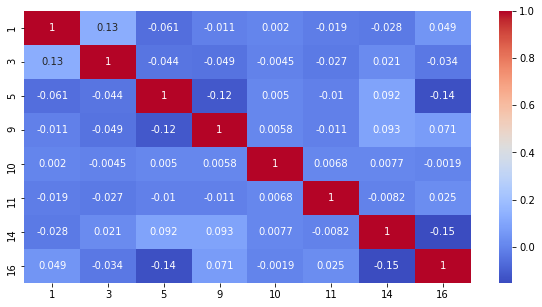

In [24]:
# Once all (assumed) relevant data has been converted to digits we can check the correlation between all columns

# Correlation matrix shows there is no clear relation between values
plt.figure(figsize = (10,5))
sns.heatmap(df_train.corr(),annot = True , cmap = "coolwarm")
plt.show()

In [25]:
# We check if there are Nan in the dataframe
df_train_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 161528 to 69647
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   5                   100000 non-null  int64  
 1   9                   99967 non-null   float64
 2   12                  100000 non-null  int64  
 3   13                  100000 non-null  int64  
 4   15                  100000 non-null  int32  
 5   17                  100000 non-null  object 
 6   TB & Chest disease  100000 non-null  uint8  
 7   anesthesia          100000 non-null  uint8  
 8   gynecology          100000 non-null  uint8  
 9   radiotherapy        100000 non-null  uint8  
 10  surgery             100000 non-null  uint8  
dtypes: float64(1), int32(1), int64(3), object(1), uint8(5)
memory usage: 5.4+ MB


In [26]:
# We check the percentage of nan values per column
percentage = df_train_reduced["9"].isna().sum() * 100 / len(df_train_reduced)
print(f"The column 'Condition of Bed in the Ward' has {percentage}% of values as nan")

The column 'Condition of Bed in the Ward' has 0.033% of values as nan


In [27]:
# We cannot replace the nan with other values as we would be assuming their value so we remove rows with nans
df_train_reduced["9"].unique()
df_train_reduced = df_train_reduced.fillna(0)

In [28]:
df_train_reduced.head()

,5,9,12,13,15,17,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
0,,,,,,,,,,,
161528,2,4.0,2,2,2,0-10,0,0,1,0,0
159472,4,2.0,1,2,5,21-30,0,0,1,0,0
309765,2,3.0,2,2,7,11-20,0,1,0,0,0
279614,3,4.0,3,2,1,51-60,0,0,1,0,0
147791,3,2.0,2,2,5,51-60,0,0,1,0,0


## 2. Defining X and y

In [29]:
X = df_train_reduced.drop(["17"], axis=1)
y = df_train_reduced["17"]

In [30]:
X.shape

(100000, 10)

In [31]:
y = np.array(y).reshape(-1,1)

## 3. Dividing X_train, X_test, y_train, y_test

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 42)

## 7. Test group

In [33]:
# Function to remove unnecesary elements
import gc
gc.collect()

18688

In [34]:
X_pred = pd.read_csv("hospital_test.csv", index_col=0)
X_pred.head()

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,,,,,,,,,,,,,,,,
314114,19,a,7,Y,4,gynecology,S,C,2.0,59278,8.0,Emergency,Minor,2,41-50,4778.0
208989,15,c,5,Z,3,gynecology,S,F,2.0,102253,15.0,Trauma,Moderate,3,31-40,5734.0
305872,17,e,1,X,4,gynecology,R,E,4.0,5828,4.0,Emergency,Minor,3,71-80,5064.0
266099,3,c,3,Z,4,TB & Chest disease,R,A,2.0,56642,9.0,Urgent,Extreme,4,31-40,3254.0
13228,6,a,6,X,4,gynecology,R,F,1.0,116266,8.0,Emergency,Minor,3,21-30,4639.0


In [35]:
# Same transformations than before to X_pred are carried out

# dummies
features_pred = X_pred["6"]
features_pred = pd.get_dummies(features_pred)

X_pred_reduced = X_pred.drop(["1","2", "3", "4","6", "10", "16", "7", "8", "11", "14"], axis=1)

X_pred_reduced = pd.concat([X_pred_reduced, features_pred], axis=1)

# encoding to numerical
X_pred_reduced["12"] = X_pred_reduced["12"].replace({'Urgent': 2, 'Trauma': 1, 'Emergency': 3})

X_pred_reduced["13"] = X_pred_reduced["13"].replace({'Moderate': 2, 'Extreme': 3, 'Minor': 1})

le = preprocessing.LabelEncoder()
data_pred = X_pred_reduced["15"].values
X_pred_reduced["15"] = le.fit_transform(data_pred)

# replace of nan
X_pred_reduced = X_pred_reduced.fillna(0)

In [36]:
X_pred_reduced

,5,9,12,13,15,TB & Chest disease,anesthesia,gynecology,radiotherapy,surgery
0,,,,,,,,,,
314114,4,2.0,3,1,4,0,0,1,0,0
208989,3,2.0,1,2,3,0,0,1,0,0
305872,4,4.0,3,1,7,0,0,1,0,0
266099,4,2.0,2,3,3,1,0,0,0,0
13228,4,1.0,3,1,2,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...
318155,6,3.0,2,1,5,0,1,0,0,0
144850,2,2.0,3,2,6,0,0,1,0,0
180676,3,3.0,1,1,3,0,0,1,0,0


## 4. Model selection

In [41]:
# Voting with RandomForest & CatBoost
from sklearn.ensemble import VotingClassifier

grad_clf = GradientBoostingClassifier(learning_rate= 0.1, max_depth= 3, max_features= "sqrt", min_samples_leaf= 2, min_samples_split= 2, n_estimators= 150, random_state= 42, warm_start= True)
cat_clf = CatBoostClassifier(random_state=42, logging_level="Silent")
rf_clf = RandomForestClassifier(random_state=42, n_estimators=500, warm_start=True, max_depth=3, max_features="sqrt", min_samples_leaf=2, min_samples_split=2)

estimators = [("gradient", grad_clf), ("forest", rf_clf)]

voting_clf = VotingClassifier(estimators, voting="soft")
voting_clf.fit(X_train, y_train)

C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


VotingClassifier(estimators=[('gradient',
                              GradientBoostingClassifier(max_features='sqrt',
                                                         min_samples_leaf=2,
                                                         n_estimators=150,
                                                         random_state=42,
                                                         warm_start=True)),
                             ('forest',
                              RandomForestClassifier(max_depth=3,
                                                     max_features='sqrt',
                                                     min_samples_leaf=2,
                                                     n_estimators=500,
                                                     random_state=42,
                                                     warm_start=True))],
                 voting='soft')

In [42]:
from sklearn.metrics import accuracy_score

def voting_prediction(models):
    
    for clf in (models):
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print (clf.__class__.__name__, metrics.accuracy_score(y_test, y_pred.ravel()))

voting_prediction(models=(grad_clf, rf_clf, voting_clf))        

C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
GradientBoostingClassifier 0.31295
ipykernel_launcher:6: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
RandomForestClassifier 0.30645
C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)
VotingClassifier 0.3095


In [39]:
# Gradient boosting - hyperparams tunning
model = GradientBoostingClassifier()

gbct_params = {
                "n_estimators": [150, 300, 500],
                "min_samples_split": [2, 3, 4, 5],
                "min_samples_leaf": [1,2,3],
                "max_depth": [2,3,4],
                "max_features": ["auto", "sqrt", "log2"],
                "learning_rate": [0.05, 0.1, 0.2],
                "warm_start": [True],
                "random_state": [42]
                }


gbct = GridSearchCV(model, 
                    gbct_params, 
                    cv=10, 
                    scoring= "accuracy",
                    n_jobs=-1)


gbct_model = gbct.fit(X_train, y_train)
y_pred_gbct = gbct_model.predict(X_test)
print("\nAccuracy score:", metrics.accuracy_score(y_test, y_pred_gbct))
print("Best params:", gbct_model.best_params_)

C:\Users\Usuario\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\utils\validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)

Accuracy score: 0.3171
Best params: {'learning_rate': 0.1, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 150, 'random_state': 42, 'warm_start': True}


In [40]:
# save final model
filename = "finished_model.sav"
pickle.dump(gbct_model, open(filename, "wb"))

In [75]:
print(gbct_model.score(X_train, y_train))
print(gbct_model.score(X_test, y_test))

0.32075
0.32745


## 8. Prediction with all data

In [ ]:
with open("finished_model.sav","rb") as f:
    loaded_model = pickle.load(f)

In [ ]:
loaded_model.fit(X,y)

In [100]:
predictions_submit = loaded_model.predict(X_pred_reduced)
predictions_submit

array(['11-20', '21-30', '11-20', ..., '11-20', '21-30', '21-30'],
      dtype=object)

## **Submission to Kaggle**


In [83]:
sample = pd.read_csv("sample_submission.csv")

In [84]:
sample.head()

,id,days
0,314114,11-20
1,208989,31-40
2,305872,81-90
3,266099,21-30
4,13228,31-40


In [85]:
id = pd.DataFrame({"id": sample["id"]})

In [101]:
predictions_submit = pd.DataFrame(predictions_submit, columns=["days"])

In [102]:
submission = pd.concat([id, predictions_submit], axis=1)
submission

,id,days
0,314114,11-20
1,208989,21-30
2,305872,11-20
3,266099,21-30
4,13228,11-20
...,...,...
133739,318155,11-20
133740,144850,11-20
133741,180676,11-20
133742,39933,21-30


## 5. Pásale el CHEQUEATOR para comprobar que efectivamente está listo para subir a Kaggle.


In [103]:
def chequeator(df_to_submit):
    """
    Esta función se asegura de que tu submission tenga la forma requerida por Kaggle.
    
    Si es así, se guardará el dataframe en un `csv` y estará listo para subir a Kaggle.
    
    Si no, LEE EL MENSAJE Y HAZLE CASO.
    
    Si aún no:
    - apaga tu ordenador, 
    - date una vuelta, 
    - enciendelo otra vez, 
    - abre este notebook y 
    - leelo todo de nuevo. 
    Todos nos merecemos una segunda oportunidad. También tú.
    """
    if df_to_submit.shape == sample.shape:
        if df_to_submit.columns.all() == sample.columns.all():
            if df_to_submit.id.all() == sample.id.all():
                print("You're ready to submit!")
                submission.to_csv("submission.csv", index = False) #muy importante el index = False
                urllib.request.urlretrieve("https://i.kym-cdn.com/photos/images/facebook/000/747/556/27a.jpg", "gfg.png")     
                img = Image.open("gfg.png")
                img.show()   
            else:
                print("Check the ids and try again")
        else:
            print("Check the names of the columns and try again")
    else:
        print("Check the number of rows and/or columns and try again")
        print("\nMensaje secreto de Clara: No me puedo creer que después de todo este notebook hayas hecho algún cambio en las filas de `diamonds_test.csv`. Lloro.")

In [104]:
chequeator(submission)

You're ready to submit!
